Todo: 
* investigate nan's in test set 
* threshold motif scores at 0 
* overlay motif scores and deepLIFT tracks 
* add grad x input 
* PRC curves 
* option of shuffled reference & background frequencies for deepLIFT 
* fixed axes on deepLIFT plots


# How to train your DragoNN tutorial 3: 
## Interpreting features induced by DNN's across multiple types of motif grammars 

This tutorial is a supplement to the DragoNN manuscript and follows figure 7 in the manuscript. 

This tutorial will take 1 hour  if executed on a GPU. 

Please complete "Primer Tutorial 1- Exploring model architectures for a homotypic motif density simulation" prior to completing this tutorial. 

The architectures used in this tutorial were determined as optimal by hyperparameter grid search in "Primer Tutorial 3 - CNN Hyperparameter Tuning via Grid Search"


## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Defining helper functions for model training and interpretation</a></li>
    TODO: explain reference options. 
    <li><a href=#3>Simulating training data with simdna: Review of Tutorial 1</a></li>
    <li><a href=#4>Single Motif</a></li>
    <li><a href=#5>Homotypic motif density detection</a></li>
    <li><a href=#6>Homotypic motif density localization</a></li>
    <li><a href=#7>Multiple motifs (multi-task)</a></li>  
    <li><a href=#8>Heterotypic motifs spatial grammar</a></li>
    <li><a href=#9>Conclusions</a></li>
</ol>
Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Jupyter/IPython Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. You can run the next cell by cliking the play button:
![play button](./primer_tutorial_images/play_button.png)
You can also run all cells in a series by clicking "run all" in the Cell drop-down menu:
![play all button](./primer_tutorial_images/play_all_button.png)
Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:
![inspecting code](./primer_tutorial_images/inspecting_code.png)


In [1]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install https://github.com/kundajelab/simdna/archive/0.3.zip
#!pip install https://github.com/kundajelab/dragonn/archive/keras_2.2_tensorflow_1.6_purekeras.zip


In [2]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')
import numpy as np 

Using TensorFlow backend.


We start by loading dragonn's tutorial utilities.

In [3]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from dragonn.tutorial_utils import *

/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Defining helper functions for model training and interpretation  <a name='2'>
<a href=#outline>Home</a>


For each type of simulation, we will perform a consistent set of tasks: 
* Define the optimal model architecture, as determined in Tutorial 2. This architecture will be specific to the simulation used, so we don't write a universal helper function for this purpose. 
* Train the model on simulation data and visualize the model's learning curve on training and validation data. 
* Compute the model's performance on a held-out test set.
* Visualize motif scores for a positive and negative example. 
* Perform in silico mutagenesis for a positive and negative example.
* Compute DeepLIFT scores for a positive and negative example.

To avoid writing the same code for each scenario, we define a series of helpers functions to perform the tasks above. 

In [4]:
from dragonn.callbacks import * 
from dragonn.tutorial_utils import plot_learning_curve

def train_model(model,data):
    #We define a custom callback to print training and validation metrics while training. 
    metrics_callback=MetricsCallback(train_data=(data.X_train,data.y_train),validation_data=(data.X_valid,data.y_valid))
    
    #Train the model 
    history=model.fit(x=data.X_train,
                                  y=data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=0,
                                  callbacks=[EarlyStopping(patience=7,restore_best_weights=True),
                                            History(),
                                            metrics_callback],
                                  validation_data=(data.X_valid,
                                                   data.y_valid))
    
    #Visualize the model's performance curve 
    plot_learning_curve(history)
    return model

In [5]:
#Compute model performance on a held out test set 
def compute_performance(model,data):
    test_predictions=model.predict(data.X_test)
    ## Generate a ClassificationResult object to print performance metrics on held-out test set 
    print(ClassificationResult(data.y_test,test_predictions))


In [6]:
def extract_pos_and_neg_validation_sample(data,pos_index,neg_index):
#get the indices of the specified positive and negative examples in the validation data split
    pos_index=np.flatnonzero(data.y_valid==1)[pos_index]
    pos_X=data.X_valid[pos_index:pos_index+1]
    neg_index=np.flatnonzero(data.y_valid==0)[neg_index]
    neg_X=data.X_valid[neg_index:neg_index+1]
    return pos_X,neg_X

In [7]:
#Visualize motif scores for a positive and negative example 
#pos_index: index value of a simulated positive datapoint to use for motif visualization 
#neg_index: index value of a simulated negative datapoint to use for motif visualization 
def visualize_motif_scores(model,pos_X,neg_X,data): 
    pos_motif_scores=get_motif_scores(pos_X,data.motif_names,return_positions=True).squeeze()
    neg_motif_scores=get_motif_scores(neg_X,data.motif_names,return_positions=True).squeeze()
    
    plt.figure(figsize=(20,3))
    ax1=plt.subplot(211)
    ax2=plt.subplot(212)
    
    ax1.plot(pos_motif_scores, "-o")
    ax1.set_ylim(0,max(pos_motif_scores))
    ax1.set_xlabel("Sequence base")
    ax1.set_ylabel("Motif scan score")
    ax1.set_title("Positive example")

    ax2.plot(neg_motif_scores, "-o")
    ax2.set_ylim(0,max(pos_motif_scores))
    ax2.set_xlabel("Sequence base")
    ax2.set_ylabel("Motif scan score")
    ax2.set_title("Negative example")
    plt.show()


In [8]:
from dragonn.tutorial_utils import in_silico_mutagenesis, plot_ism

def perform_ism(model,pos_X,neg_X,data): 
    ism_pos=in_silico_mutagenesis(model,pos_X)
    ism_neg=in_silico_mutagenesis(model,neg_X)
    min_val=min([np.amin(ism_pos),np.amin(ism_neg)])
    max_val=max([np.amax(ism_pos),np.amax(ism_neg)])
    plot_ism(ism_pos,"Positive Example",min_val=min_val,max_val=max_val)
    plot_ism(ism_neg,"Negative Example",min_val=min_val,max_val=max_val)
    return ism_pos, ism_neg

In [9]:
from dragonn.tutorial_utils import input_grad

def compute_gradxinput_scores(model,pos_X,neg_X,data):
    gradinput_pos=input_grad(model,pos_X)
    gradinput_neg=input_grad(model,neg_X)
    min_val=min([np.amin(gradinput_pos),np.amin(gradinput_neg)])
    max_val=max([np.amax(gradinput_pos),np.amax(gradinput_neg)])
    plot_seq_importance(gradinput_pos,pos_X,title="Positive",ylim=(min_val,max_val))
    plot_seq_importance(gradinput_neg,neg_X,title="Negative",ylim=(min_val,max_val))
    return gradinput_pos,gradinput_neg 

In [10]:
from dragonn.tutorial_utils import deeplift

def compute_deeplift_scores(model,pos_X,neg_X,data):
    dl_pos=deeplift(model,pos_X)
    dl_neg=deeplift(model,neg_X)
    min_val=min([np.amin(gradinput_pos),np.amin(gradinput_neg)])
    max_val=max([np.amax(gradinput_pos),np.amax(gradinput_neg)])
    plot_seq_importance(dl_pos,pos_X,title="Positive",ylim=(min_val,max_val))
    plot_seq_importance(dl_neg,neg_X,title="Negative",ylim=(min_val,max_val))
    return dl_pos,dl_neg

In [11]:
def interpret(model,pos_X,neg_X,data): 
    visualize_motif_scores(model,pos_X,neg_X,data)
    ism_pos,ism_neg=perform_ism(model,pos_X,neg_X,data)
    gradinput_pos,gradinput_neg=compute_gradxinput_scores(model,pos_X,neg_X,data)
    dl_pos,dl_neg=compute_deeplift_scores(model,pos_X,neg_X,data)
    return ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg 

In [12]:
#Run the full data analysis for a given dataset and model 
#Train the model, compute it's performance on a positive and negative data point 
def analyze(model,data,pos_index,neg_index):
    model=train_model(model,data)
    compute_performance(model,data)
    pos_X,neg_X=extract_pos_and_neg_validation_sample(data,pos_index,neg_index)
    ism_pos,ism_neg, gradinput_pos, gradinput_neg, dl_pos,dl_neg=interpret(model,pos_X,neg_X,data)
    return pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos,dl_neg

Finally, we set a random seed to ensure that all analyses in this tutorial are reproducible. 

In [13]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

## Getting simulation data <a name='3'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. Let's use the **print_available_simulations** function to examine the list of simulations supported by DragoNN:

In [14]:
print_available_simulations()

simulate_differential_accessibility
simulate_heterodimer_grammar
simulate_motif_counting
simulate_motif_density_localization
simulate_multi_motif_embedding
simulate_single_motif_detection


## Single Motif <a name='4'>
<a href=#outline>Home</a>


We begin with single motif detection of the TAL1_known4 motif: 

![play button](./primer_tutorial_images/TAL1_known4.png)
Let's find out what parameters are needed for the simulation: 

In [15]:
print_simulation_info("simulate_single_motif_detection")


    Simulates two classes of seqeuences:
        - Positive class sequence with a motif
          embedded anywhere in the sequence
        - Negative class sequence without the motif

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Array with sequence strings.
    y : 1darray
        Array with positive/negative class labels.
    embedding_arr: 1darray
        Array of embedding objects.
    


In this binary simulation task, we simulate a negative set of 10K 500 bp random sequences and a positive set of 10K 500 bp random sequences with one instance of the TAL1 motif randomly embedded at any position.

In [16]:
#Define simulation parameters 
tal1_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 500, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data 
tal1_data = get_simulation_data("simulate_single_motif_detection",
                                      tal1_parameters,
                                      validation_set_size=3200, test_set_size=4000)


We define the convolutional neural network model architecture: 

In [17]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
tal1_model=Sequential() 
tal1_model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=tal1_data.X_train.shape[1::]))
tal1_model.add(Activation('relu'))
tal1_model.add(MaxPooling2D(pool_size=(1,35)))
tal1_model.add(Flatten())
tal1_model.add(Dense(1))
tal1_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
tal1_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

Training Data:
Loss: 0.6926	Balanced Accuracy: 52.35%	 auROC: 0.531	 auPRC: 0.524
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.6966	Balanced Accuracy: 50.91%	 auROC: 0.504	 auPRC: 0.506
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.6887	Balanced Accuracy: 53.47%	 auROC: 0.557	 auPRC: 0.547
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.6954	Balanced Accuracy: 50.67%	 auROC: 0.515	 auPRC: 0.515
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.6845	Balanced Accuracy: 55.63%	 auROC: 0.582	 auPRC: 0.572
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.6933	Balanced Accuracy: 52.67%	 auROC: 0.531	 auPRC: 0.528
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 1617	 Num Negatives: 158

Training Data:
Loss: 0.4522	Balanced Accuracy: 81.62%	 auROC: 0.889	 auPRC: 0.874
	Recall at 5%|10%|20% FDR: 2.1%|50.9%|84.9%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.4802	Balanced Accuracy: 79.00%	 auROC: 0.863	 auPRC: 0.856
	Recall at 5%|10%|20% FDR: 5.2%|46.3%|77.6%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.4412	Balanced Accuracy: 82.41%	 auROC: 0.897	 auPRC: 0.882
	Recall at 5%|10%|20% FDR: 15.1%|55.3%|87.0%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.4717	Balanced Accuracy: 79.40%	 auROC: 0.872	 auPRC: 0.865
	Recall at 5%|10%|20% FDR: 5.4%|49.8%|80.8%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.4312	Balanced Accuracy: 83.38%	 auROC: 0.902	 auPRC: 0.886
	Recall at 5%|10%|20% FDR: 16.1%|58.0%|88.8%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.4592	Balanced Accuracy: 80.61%	 auROC: 0.878	 auPRC: 0.870
	Recall at 5%|10%|20% FDR: 4.7%|50.5%|82.5%	 Num Positives: 1617	 Num 

Training Data:
Loss: 0.3107	Balanced Accuracy: 89.92%	 auROC: 0.942	 auPRC: 0.933
	Recall at 5%|10%|20% FDR: 57.0%|89.1%|94.8%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3504	Balanced Accuracy: 87.91%	 auROC: 0.921	 auPRC: 0.916
	Recall at 5%|10%|20% FDR: 49.9%|82.1%|92.9%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.3113	Balanced Accuracy: 89.30%	 auROC: 0.943	 auPRC: 0.934
	Recall at 5%|10%|20% FDR: 57.7%|89.5%|94.9%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3560	Balanced Accuracy: 86.73%	 auROC: 0.921	 auPRC: 0.917
	Recall at 5%|10%|20% FDR: 51.0%|82.1%|93.0%	 Num Positives: 1617	 Num Negatives: 1583
Training Data:
Loss: 0.3068	Balanced Accuracy: 89.91%	 auROC: 0.943	 auPRC: 0.934
	Recall at 5%|10%|20% FDR: 57.7%|89.7%|95.0%	 Num Positives: 6401	 Num Negatives: 6399
Validation Data:
Loss: 0.3503	Balanced Accuracy: 87.52%	 auROC: 0.921	 auPRC: 0.917
	Recall at 5%|10%|20% FDR: 50.6%|81.6%|92.9%	 Num Positives: 1617	 

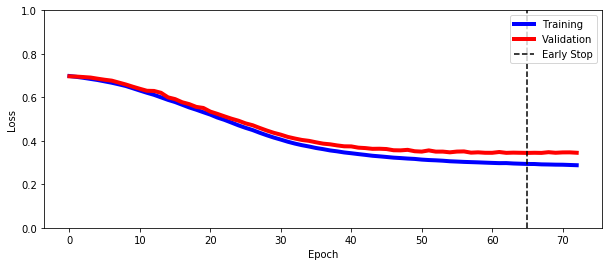

Loss: 0.3302	Balanced Accuracy: 89.11%	 auROC: 0.929	 auPRC: 0.920
	Recall at 5%|10%|20% FDR: 23.7%|85.9%|94.0%	 Num Positives: 1982	 Num Negatives: 2018


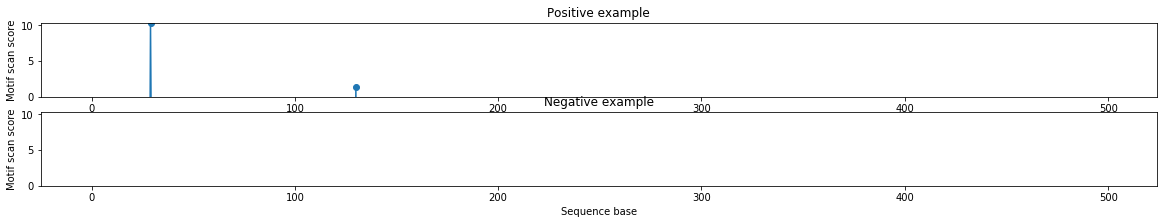

TypeError: plot_ism() got an unexpected keyword argument 'min_val'

In [18]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(tal1_model,tal1_data,1,1)

Let's zoom in to the portion of the deepLIFT track with the strongest signal:

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive Zoomed")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative Zoomed")

## Homotypic motif density detection <a name='5'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
density_detection_parameters={
    "motif_name": "TAL1_known4",
    "seq_length": 500,
    "neg_counts":[0,2],
    "pos_counts":[3,5],
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction":0.4
}

#Get simulation data
density_detection_data=get_simulation_data("simulate_motif_counting",
                               density_detection_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [ ]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
density_detection_model=Sequential() 
density_detection_model.add(Conv2D(filters=10,kernel_size=(1,15),input_shape=density_detection_data.X_train.shape[1::]))
density_detection_model.add(Activation('relu'))
density_detection_model.add(MaxPooling2D(pool_size=(1,35)))
density_detection_model.add(Flatten())
density_detection_model.add(Dense(1))
density_detection_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
density_detection_model.compile(optimizer='adam',
                               loss='binary_crossentropy')


In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(density_detection_model,density_detection_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(200,350),title="Positive, Zoomed")
plot_seq_importance(dl_neg,neg_X,xlim=(200,350),title="Negative, Zoomed")

## Homotypic motif density localization <a name='6'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
density_localization_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1000,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
density_localization_data=get_simulation_data("simulate_motif_density_localization",
                               density_localization_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [ ]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
density_localization_model=Sequential() 
density_localization_model.add(Conv2D(filters=5,kernel_size=(1,10),input_shape=density_localization_data.X_train.shape[1::]))
density_localization_model.add(Activation('relu'))
density_localization_model.add(MaxPooling2D(pool_size=(1,10)))
density_localization_model.add(Flatten())
density_localization_model.add(Dense(1))
density_localization_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
density_localization_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(density_localization_model,density_localization_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Multiple motifs (multi-task)<a name='7'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
multi_motif_parameters = {
    "motif_names": ["CTCF_known1","ZNF143_known2","SIX5_known1"],
    "seq_length": 500,
    "min_num_motifs": 0,
    "max_num_motifs": 1, 
    "num_seqs": 20000,
    "GC_fraction": 0.4}

#Get simulation data
multi_motif_data=get_simulation_data("simulate_multi_motif_embedding",
                               multi_motif_parameters,
                               validation_set_size=3200,test_set_size=4000)



In [ ]:
#Define the optimal model architecture in keras (Refer to Primer Tutorial 2)
multi_motif_model=Sequential() 
multi_motif_model.add(Conv2D(filters=20,kernel_size=(1,20),input_shape=multi_motif_data.X_train.shape[1::]))
multi_motif_model.add(Activation('relu'))
multi_motif_model.add(MaxPooling2D(pool_size=(1,10)))
multi_motif_model.add(Flatten())
multi_motif_model.add(Dense(3))
multi_motif_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_motif_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(multi_motif_model, multi_motif_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Heterotypic motifs spatial grammar<a name='8'>
<a href=#outline>Home</a>

In [ ]:
#Define simulation parameters 
heterodimer_parameters = {
    "motif1": "SPI1_known4",
    "motif2": "IRF_known1",
    "seq_length": 500,
    "min_spacing": 2,
    "max_spacing": 5, 
    "num_pos": 10000,
    "num_neg": 10000,
    "GC_fraction": 0.4}

#Get simulation data
heterodimer_data=get_simulation_data("simulate_heterodimer_grammar",
                               heterodimer_parameters,
                               validation_set_size=3200,test_set_size=4000)

In [ ]:
heterodimer_model=Sequential()
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(Conv2D(filters=15,kernel_size=(1,15),input_shape=input_shape))
heterodimer_model.add(Activation("relu"))
heterodimer_model.add(MaxPooling2D(pool_size=(1,35)))    
heterodimer_model.add(Flatten())
heterodimer_model.add(Dense(num_tasks))
heterodimer_model.add(Activation("sigmoid"))
heterodimer_model.compile(optimizer='adam',loss='binary_crossentropy')


In [ ]:
pos_X, neg_X, ism_pos, ism_neg, gradinput_pos, gradinput_neg, dl_pos, dl_neg=analyze(heterodimer_model,heterodimer_data,1,1)

In [ ]:
plot_seq_importance(dl_pos,pos_X,xlim=(220,275),title="Positive")
plot_seq_importance(dl_neg,neg_X,xlim=(220,275),title="Negative")

## Conclusions<a name='9'>
<a href=#outline>Home</a>